In [2]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = './data/'

In [4]:
### Load the main data

data = pd.read_csv(
    path+'ratings.dat',
    sep='::',
    engine='python',
    header=None,
    encoding='latin1')


In [4]:
### Upload the Movie data
column_names = ['movieId', 'title', 'genres']
movie = pd.read_csv(
    path+'movies.dat',
    sep='::',
    engine='python',
    header=None,
    names=column_names,
    encoding='latin1')


In [5]:
genre = movie['genres']

## Get unique genre

In [6]:
all_genres = {}
for row in genre:
    _genre = row.split('|')
    for unique_genre in _genre:
        if unique_genre not in all_genres:
            all_genres[unique_genre] = len(all_genres)

# genre2Id = genres_split.apply(lambda x: [genre_to_id[genre] for genre in x])
genre_split = genre.str.split('|')
genre2Id = genre_split.apply(lambda x: [all_genres[genre] for genre in x])

## Genre to Id

In [7]:
movie['genreId'] = genre2Id

# Create the sparse matrix

In [8]:
def sparse_matrix(data):

    # Extract user, movie, rating columns from data
    user, movie, rating = data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2]

    # mapping from user to index
    map_user_to_index = {}
    map_index_to_user = []

    # mapping from movie to index
    map_movie_to_index = {}
    map_index_to_movie = []


    for user_id, movie_id  in zip(user, movie):
        if user_id not in map_user_to_index.keys():
            index_user = len(map_index_to_user)
            map_index_to_user.append(user_id)
            map_user_to_index[user_id] = index_user
        else:
            index_user = map_user_to_index[user_id]

        if movie_id not in map_movie_to_index.keys():
            index_movie = len(map_index_to_movie)
            map_index_to_movie.append(movie_id)
            map_movie_to_index[movie_id] = index_movie
        else:
            index_movie = map_movie_to_index[movie_id]

    #Initialize with empty list all the trainings data.
    user_data_train = [[] for i in range(len(map_index_to_user))]
    movie_data_train = [[] for i in range(len(map_index_to_movie))]

    #Initialize with empty list all the test data.
    user_data_test = [[] for i in range(len(map_index_to_user))]
    movie_data_test = [[] for i in range(len(map_index_to_movie))]

    counter = 0
    for U_Id, M_Id, rat in zip(user, movie, rating):
        User_Id = map_user_to_index[U_Id]
        Movie_Id = map_movie_to_index[M_Id]

        if counter < int(0.9 * len(data)):  # Put 90% of the data into the training data
            user_data_train[User_Id].append((Movie_Id, rat))
            movie_data_train[Movie_Id].append((User_Id, rat))
        else:
            user_data_test[User_Id].append((Movie_Id, rat))
            movie_data_test[Movie_Id].append((User_Id, rat))
        counter += 1

    return user_data_train, movie_data_train, user_data_test, movie_data_test, map_user_to_index, map_index_to_user, map_movie_to_index, map_index_to_movie

In [9]:

user_data_train, movie_data_train, user_data_test, movie_data_test, map_user_to_index, map_index_to_user, map_movie_to_index, map_index_to_movie = sparse_matrix(data)

In [14]:
# Transform it into dictionary
movie_dict = {}
for index, row in movie.iterrows():
    movie_id = row['movieId']
    title = row['title']
    genres = row['genres']
    movie_dict[movie_id] = {'title': title, 'genres': genres}

# Initialize the mappings
genre_to_movies = {}
movie_to_genres = {}

# Populate the mappings
for movie_index, movie_info in movie_dict.items():
    if movie_index in map_movie_to_index:
        movie_internal_index = map_movie_to_index[movie_index]
        genres = movie_info['genres'].split('|')

        for genre in genres:
            if genre not in genre_to_movies:
                genre_to_movies[genre] = []
            genre_to_movies[genre].append(movie_internal_index)

            if movie_internal_index not in movie_to_genres:
                movie_to_genres[movie_internal_index] = []
            movie_to_genres[movie_internal_index].append(genre)


In [15]:
### Hyperparameter Initialization

lmbda = 0.005       # <--- lambda
tau = 0.01
gamma = 0.5
latent_dim = 10      # <--- K
mu = 0
sigma = 1/np.sqrt(latent_dim)
feature_dim = len(genre_to_movies)

In [16]:
#### Compute and update biases
def compute_bias(sparse_user,
                 sparse_movie,
                 user_matrix,
                 movie_matrix,
                 user_bias,
                 movie_bias
                ):

    # Update user biases
    for user_Id in range(len(sparse_user)):
        bias = 0
        movie_counter = 0
        for movie_Id, rat in sparse_user[user_Id]:
            bias += lmbda * (rat- (np.dot(user_matrix[user_Id,:].T, movie_matrix[movie_Id,:]) + movie_bias[movie_Id]))
            movie_counter += 1

        bias = bias/ (lmbda * movie_counter + gamma)
        user_bias[user_Id] = bias

    # Update movie biases
    for movie_Id in range(len(sparse_movie)):
        bias = 0
        user_counter = 0
        for user_Id, rat in sparse_movie[movie_Id]:
            bias += lmbda * (rat - (np.dot(movie_matrix[movie_Id,:].T, user_matrix[user_Id,:]) + user_bias[user_Id]))
            user_counter += 1
        bias = bias/ (lmbda * user_counter + gamma)
        movie_bias[movie_Id] = bias

In [17]:
def update_matrices(
        sparse_user,
        sparse_movie,
        user_matrix,
        movie_matrix,
        user_bias,
        movie_bias
                    ):

    # Update user matrix
    for user_Id in range(len(sparse_user)):
        if not sparse_user[user_Id]:
            continue

        U_left = 0
        U_right = 0

        for movie_Id, rat in sparse_user[user_Id]:
            U_left += lmbda * np.outer(movie_matrix[movie_Id,:], movie_matrix[movie_Id,:])
            U_right += lmbda * movie_matrix[movie_Id] * (rat - user_bias[user_Id] - movie_bias[movie_Id])

        U_left += tau * np.eye(latent_dim)
        user_matrix[user_Id] = np.dot(np.linalg.inv(U_left), U_right)

    # Update movie matrix
    for movie_Id in range(len(sparse_movie)):
        if not sparse_movie[movie_Id]:
            continue

        M_left = 0
        M_right = 0
        for user_Id, rat in sparse_movie[movie_Id]:
            M_left += lmbda * np.outer(user_matrix[user_Id,:], user_matrix[user_Id,:])
            M_right += lmbda * user_matrix[user_Id] * (rat - movie_bias[movie_Id] - user_bias[user_Id])

        M_left += tau * np.eye(latent_dim)
        movie_matrix[movie_Id] = np.dot(np.linalg.inv(M_left), M_right)

In [18]:
### Compute Root Mean Square Error
def root_mean_square(user_data, user_matrix, movie_matrix, user_bias, movie_bias):

    err = 0
    num_rating = 0

    for user_Id in range(len(user_data)):
        for movie_Id ,rating in user_data[user_Id]:
            pred = (user_matrix[user_Id].T @ movie_matrix[movie_Id] + user_bias[user_Id] + movie_bias[movie_Id])
            err += (rating - pred) ** 2
        num_rating += len(user_data[user_Id])

    Error = err / num_rating

    return np.sqrt(Error)

In [19]:
# Initialize feature vectors
feature_vector = {}
for genre in genre_to_movies:
    feature_vector[genre] = np.random.normal(mu, sigma, size=(latent_dim))

def update_features(features):
    for feature_index in features:
        s_fn = 0
        s_vec = np.zeros(latent_dim)
        feature_items = genre_to_movies[feature_index]
        for item_index in feature_items:
            fn = len(movie_to_genres[item_index])
            s_fn = s_fn + 1 / fn
            s_fl = np.zeros(latent_dim)
            for l in movie_to_genres[item_index]:
                if l != feature_index:
                    s_fl = s_fl + feature_vector[l]

            s_vec = s_vec + movie_matrix_train[item_index] / np.sqrt(fn) - 1 / fn * s_fl
        feature_vector[feature_index] = (1 / (1 + s_fn)) * s_vec

In [21]:
def loss_function(
        user_data,
        movie_data,
        user_matrix,
        movie_matrix,
        user_Bias,
        movie_Bias,
        feature_vector
        ):

    diff = 0
    user_sum = 0
    movie_sum = 0
    feature_sum = 0

    for userId in range(len(user_data)):
        for movieId, rat in user_data[userId]:
            if len(user_data[userId]) == 0:
                continue
            else:
                matrix_user_movie = np.dot(user_matrix[userId,:].T, movie_matrix[movieId,:])
                diff += (rat - (matrix_user_movie + user_Bias[userId] + movie_Bias[movieId]))**2

    for U_id in range(len(user_data)):
        user_sum += np.dot(user_matrix[U_id].T , user_matrix[U_id])

    for M_id in range(len(movie_data)):
        fn = len(movie_to_genres[M_id])
        genre_sum = np.zeros(latent_dim)

        for genre in movie_to_genres[M_id]:
            genre_sum += feature_vector[genre]

        movie_vector = movie_matrix[M_id] - (1 / np.sqrt(fn)) * genre_sum
        movie_sum += np.dot(movie_vector.T, movie_vector)

    for feature in feature_vector:
        feature_sum += np.dot(feature_vector[feature].T, feature_vector[feature])

    U = np.dot(user_Bias, user_Bias)
    V = np.dot(movie_Bias, movie_Bias)

    loss = ((lmbda*diff) + (gamma*U) + (tau*user_sum) + (gamma*V) + (tau*movie_sum) + (tau*feature_sum))/2

    return loss


In [22]:
# @title Default title text
### Create function for plotting
def plot_(iteration_number, loss_values_train, loss_values_test, ylabel, Figure_name, plot_title):

    # Plot initialization
    plt.figure(figsize=(10, 6))
    plt.gca()
    ax = plt.gca()

    # Plot the training loss with a blue line
    plt.plot(iteration_number, loss_values_train, marker='o', color='black', label="Training Loss")

    # Plot the test loss with a red line
    plt.plot(iteration_number, loss_values_test, marker='o', color='red', label="Test Loss")

    # x and y label
    ax.set_xlabel('Iteration', labelpad=10, fontsize=14)
    ax.set_ylabel(ylabel+'value', labelpad=10, fontsize=14)

    # Plot title
    ax.set_title(plot_title, fontsize=14)

    # Add a legend to the plot
    plt.legend()
    plt.grid(True)

    ax.tick_params(axis='both', which='both', direction='in', length=5, width=1, pad=6)
    ax.tick_params(which='minor', length=3)

    # Remove top and right axis
    ax.spines[['right', 'top']].set_visible(False)

    plt.show()

In [23]:
# train matrices

user_matrix_train = np.random.normal(mu, sigma, size=(len(user_data_train), latent_dim))
movie_matrix_train = np.random.normal(mu, sigma, size=(len(movie_data_train), latent_dim))
user_biases_train = np.zeros((len(user_data_train)))
movie_biases_train = np.zeros((len(movie_data_train)))

# test matrices

user_matrix_test = np.random.normal(mu, sigma, size=(len(user_data_test), latent_dim))
movie_matrix_test = np.random.normal(mu, sigma, size=(len(movie_data_test), latent_dim))
user_biases_test = np.zeros((len(user_data_test)))
movie_biases_test = np.zeros((len(movie_data_test)))

In [24]:
### With feature vector
#### Traind the model
def train_and_evaluate(iteration):
    iteration_number, loss_values_train, loss_values_test, error_train, error_test = [], [], [], [], []

    for iter in range(iteration):
        # loss function for the train data
        compute_bias(user_data_train,
                     movie_data_train,
                     user_matrix_train,
                     movie_matrix_train,
                     user_biases_train,
                     movie_biases_train)

        update_matrices(user_data_train,
                        movie_data_train,
                        user_matrix_train,
                        movie_matrix_train,
                        user_biases_train,
                        movie_biases_train)

        update_features(genre_to_movies.keys())

        loss_values_train.append(loss_function(
            user_data_train,
            movie_data_train,
            user_matrix_train,
            movie_matrix_train,
            user_biases_train,
            movie_biases_train,
            feature_vector
            )
        )

        # loss function for the test data
        compute_bias(user_data_test,
                     movie_data_test,
                     user_matrix_test,
                     movie_matrix_test,
                     user_biases_test,
                     movie_biases_test)

        update_matrices(user_data_test,
                        movie_data_test,
                        user_matrix_test,
                        movie_matrix_test,
                        user_biases_test,
                        movie_biases_test)

        loss_values_test.append(loss_function(user_data_test,
                                              movie_data_test,
                                              user_matrix_test,
                                              movie_matrix_test,
                                              user_biases_test,
                                              movie_biases_test,
                                              feature_vector))

        rmse_train = root_mean_square(user_data_train,
                                      user_matrix_train,
                                      movie_matrix_train,
                                      user_biases_train,
                                      movie_biases_train)

        rmse_test = root_mean_square(user_data_test,
                                     user_matrix_test,
                                     movie_matrix_test,
                                     user_biases_test,
                                     movie_biases_test)

        error_train.append(rmse_train)
        error_test.append(rmse_test)

        iteration_number.append(iter)

    return loss_values_train, loss_values_test, error_train, error_test, iteration_number

In [26]:
iteration = 12
loss_train, loss_test, error_train, error_test, iteration_number = train_and_evaluate(iteration)

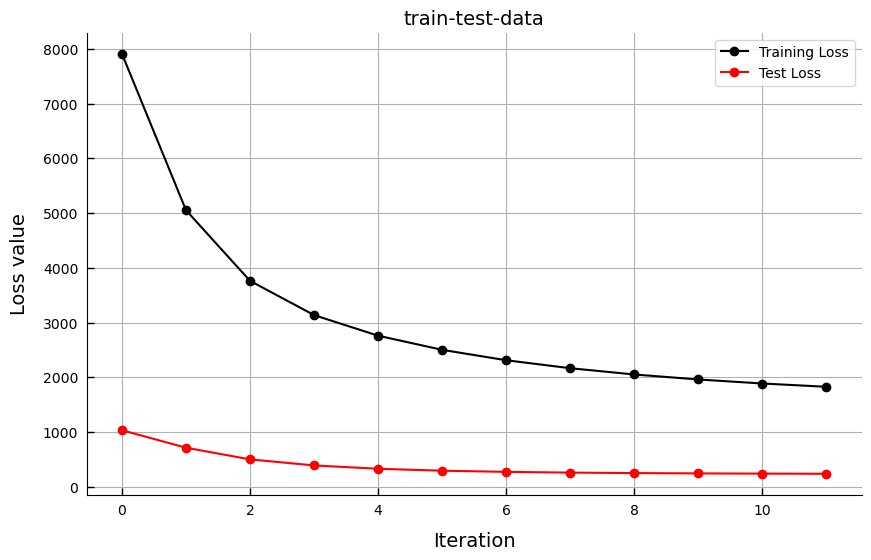

In [27]:
### Plot the loss function
plot_(iteration_number, loss_train, loss_test, 'Loss ', 'Loss_train_test', 'train-test-data')

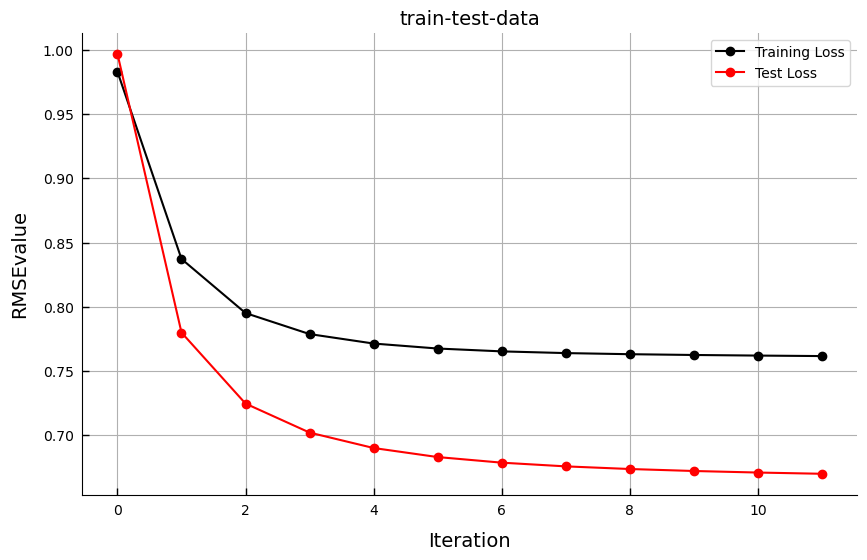

In [28]:
plot_(iteration_number, error_train, error_test, 'RMSE', 'RMSE_train_test', 'train-test-data')

In [29]:
### Map movie title and genre
def get_movie_title(movie_index):
    movie_sys = map_index_to_movie[movie_index]
    movie_title = movie_dict[movie_sys]['title']
    return movie_title

In [30]:
def get_movie_genre(movie_index):
    movie_sys = map_index_to_movie[movie_index]
    movie_genres = movie_dict[movie_sys]['genres']
    return movie_genres

In [31]:
### Function to search movie title in movie.csv
def search_movieId_by_title(title_to_search):

    movie_results = []
    title_to_search = title_to_search.lower()

    for movie_id, movie_info in movie_dict.items():
        if title_to_search in movie_info['title'].lower():
            if movie_id in map_movie_to_index:
                movie_results.append([map_movie_to_index[movie_id], movie_info['title'], movie_info['genres']])

    return movie_results

In [35]:
def recommend_movies_for_user(
        user_movie_ids,
        movie_matrix,
        movie_biases,
        num_recommendations=15,
        regularization_factor=0.9):

    # Aggregate user preferences across all watched movies
    user_preference_vector = np.zeros_like(movie_matrix[0])
    for movie_id in user_movie_ids:
        user_preference_vector += movie_matrix[movie_id]

    # Normalize preference vector
    user_preference_vector /= len(user_movie_ids)

    _recommended_movies = []

    # Calculate preference scores for each movie
    for movie_id in range(len(movie_matrix)):
        preference_score = np.dot(
            user_preference_vector,
            movie_matrix[movie_id, :]
            ) + regularization_factor * movie_biases[movie_id]

        _recommended_movies.append((movie_id, preference_score))

    # Sort movies by preference score in descending order
    _recommended_movies = sorted(_recommended_movies, key=lambda x: x[1], reverse=True)

    # Get the top N recommended movies
    _recommended_movies = _recommended_movies[:num_recommendations]

    return _recommended_movies


In [36]:
user_movie_ids = [346, 2905, 719, 322, 760, 528]  # Example list of movie IDs watched by the user
result_recommend_movies = recommend_movies_for_user(user_movie_ids, movie_matrix_train, movie_biases_train)

print(f"The user watched:")
for id in user_movie_ids:
    print(f"{get_movie_title(id)}\t{get_movie_genre(id)}")

print()
print("Recommended Movies:")
for movie_id, preference_score in result_recommend_movies:
    print(movie_id, get_movie_title(movie_id), get_movie_genre(movie_id))


The user watched:
My Life in Pink (Ma vie en rose) (1997)	Comedy|Drama
Nénette et Boni (1996)	Drama
African Queen, The (1951)	Action|Adventure|Romance|War
Gattaca (1997)	Drama|Sci-Fi|Thriller
Buffy the Vampire Slayer (1992)	Comedy|Horror
Star Trek: First Contact (1996)	Action|Adventure|Sci-Fi

Recommended Movies:
44 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Fantasy|Sci-Fi
124 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Drama|Sci-Fi|War
127 Raiders of the Lost Ark (1981) Action|Adventure
132 Matrix, The (1999) Action|Sci-Fi|Thriller
38 Sixth Sense, The (1999) Thriller
134 Shakespeare in Love (1998) Comedy|Romance
64 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Romance|Sci-Fi|War
5 Princess Bride, The (1987) Action|Adventure|Comedy|Romance
273 Ghostbusters (1984) Comedy|Horror
97 Terminator 2: Judgment Day (1991) Action|Sci-Fi|Thriller
22 Back to the Future (1985) Comedy|Sci-Fi
189 Men in Black (1997) Action|Adventure|Come